In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/avazu-ctr-prediction/sampleSubmission.gz
/kaggle/input/avazu-ctr-prediction/train.gz
/kaggle/input/avazu-ctr-prediction/test.gz


In [2]:
import pandas as pd
import gzip
import random

In [3]:
n = 40428967  #total number of records in the clickstream data 
sample_size = 2000000
skip_values = sorted(random.sample(range(1,n), n-sample_size))

parse_date = lambda val : pd.datetime.strptime(val, '%y%m%d%H')
with gzip.open('../input/avazu-ctr-prediction/train.gz') as f:
    train = pd.read_csv(f,skiprows = skip_values)
train['hour'] = pd.to_datetime(train['hour'],format = '%y%m%d%H')    

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

# Exploratory Data Analysis


In [5]:
print(train.columns)
print(train.dtypes)

Index(['id', 'click', 'hour', 'C1', 'banner_pos', 'site_id', 'site_domain',
       'site_category', 'app_id', 'app_domain', 'app_category', 'device_id',
       'device_ip', 'device_model', 'device_type', 'device_conn_type', 'C14',
       'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21'],
      dtype='object')
id                          uint64
click                        int64
hour                datetime64[ns]
C1                           int64
banner_pos                   int64
site_id                     object
site_domain                 object
site_category               object
app_id                      object
app_domain                  object
app_category                object
device_id                   object
device_ip                   object
device_model                object
device_type                  int64
device_conn_type             int64
C14                          int64
C15                          int64
C16                          int64
C17                      

## For missing values

In [7]:
print(train.info())
print(train.isnull().sum().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000000 entries, 0 to 1999999
Data columns (total 24 columns):
 #   Column            Dtype         
---  ------            -----         
 0   id                uint64        
 1   click             int64         
 2   hour              datetime64[ns]
 3   C1                int64         
 4   banner_pos        int64         
 5   site_id           object        
 6   site_domain       object        
 7   site_category     object        
 8   app_id            object        
 9   app_domain        object        
 10  app_category      object        
 11  device_id         object        
 12  device_ip         object        
 13  device_model      object        
 14  device_type       int64         
 15  device_conn_type  int64         
 16  C14               int64         
 17  C15               int64         
 18  C16               int64         
 19  C17               int64         
 20  C18               int64         
 21  C19     

There are no missing values in the dataset.

## id

In [8]:
train.drop('id',axis=1,inplace = True)

## Timestamp - Hour

In [9]:
train['day_week'] = train['hour'].apply(lambda x: x.dayofweek)
train['hour_day'] = train['hour'].apply(lambda x: x.hour)

Text(0.5, 1.0, 'Hours of a day')

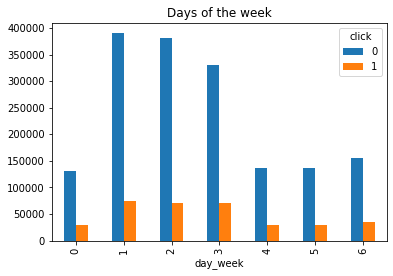

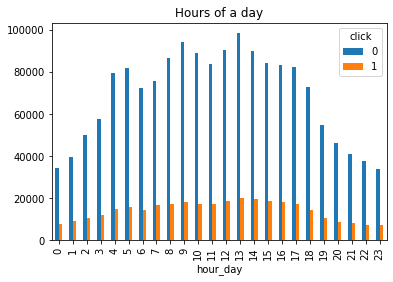

In [10]:
train.groupby(['day_week','click']).size().unstack().plot(kind='bar')
plt.title('Days of the week')
train.groupby(['hour_day','click']).size().unstack().plot(kind='bar')
plt.title('Hours of a day')

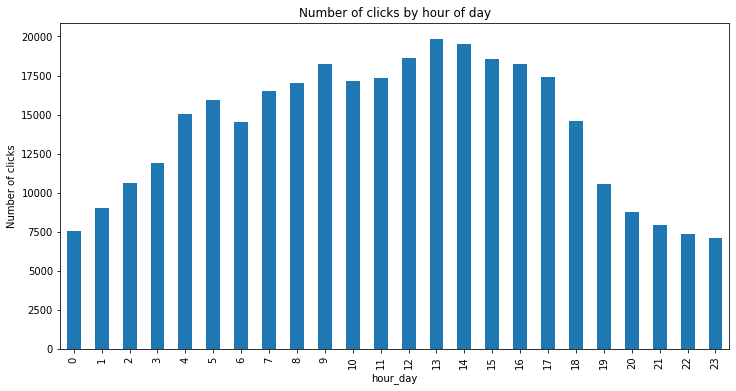

In [11]:
train.groupby('hour_day')['click'].sum().plot.bar(figsize=(12,6))
plt.ylabel('Number of clicks')
plt.title('Number of clicks by hour of day')
plt.show()

## Click

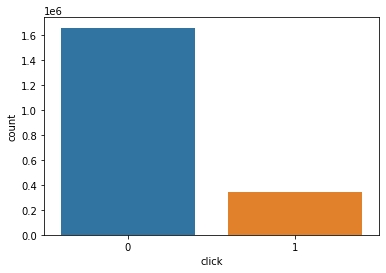

0    0.830302
1    0.169698
Name: click, dtype: float64


In [12]:
sns.countplot(x='click',data=train)
plt.show()
print(train.click.value_counts()/len(train))

Nearly 17% is the CTR of the data provided.

## Banner Position

<AxesSubplot:ylabel='banner_pos'>

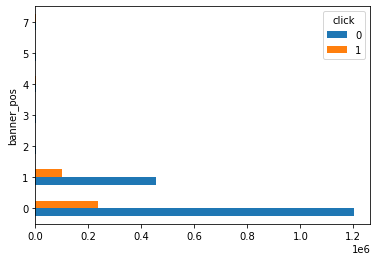

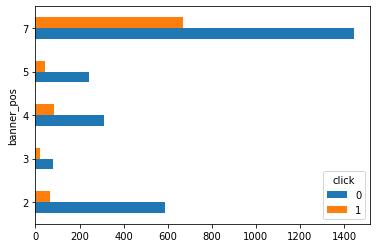

In [13]:
train.groupby(['banner_pos', 'click']).size().unstack().plot(kind='barh')
train.groupby(['banner_pos','click']).size().unstack().iloc[2:,:].plot(kind='barh')

In [14]:
site_features = ['site_id', 'site_domain', 'site_category']
train[site_features].describe()

,site_id,site_domain,site_category
count,2000000,2000000,2000000
unique,2998,3446,23
top,85f751fd,c4e18dd6,50e219e0
freq,723537,750159,819490


## Hashing


In [15]:
# Get categorical columns
categorical_cols = train.select_dtypes(
  include = ['object']).columns.tolist()
print("Categorical columns: ")
print(categorical_cols)

# Iterate over categorical columns and apply hash function
for col in categorical_cols:
	train[col] = train[col].apply(lambda x: hash(x))

Categorical columns: 
['site_id', 'site_domain', 'site_category', 'app_id', 'app_domain', 'app_category', 'device_id', 'device_ip', 'device_model']


## Feature Selection

<AxesSubplot:>

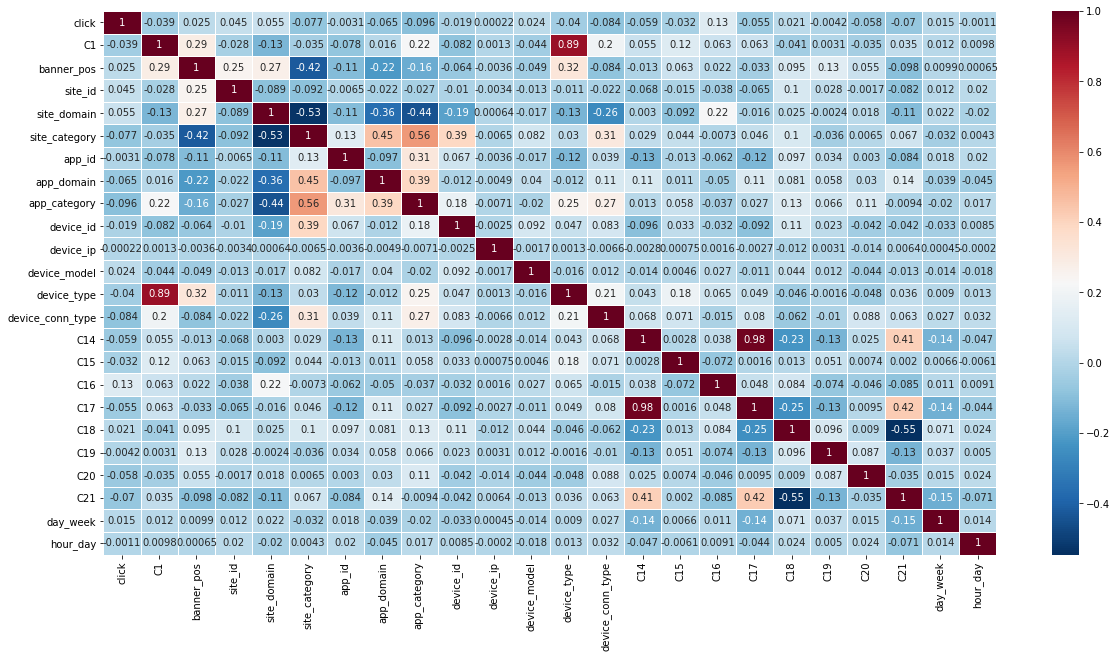

In [16]:
ad_corr = train.corr(method = 'pearson')
fig,ax = plt.subplots(figsize = (20,10))
sns.heatmap(ad_corr,
            xticklabels=ad_corr.columns,
            yticklabels=ad_corr.columns,
            cmap='RdBu_r',
            annot=True,
            linewidth=1,ax=ax)

We can remove the features which are irrelavant to the data, and not useful.

In [17]:
from sklearn.model_selection import train_test_split
X = train.drop(['device_id','device_ip','hour','click'],axis=1)
y = train.click
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,random_state=21)

In [18]:
x_train.head()

,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_model,device_type,...,C14,C15,C16,C17,C18,C19,C20,C21,day_week,hour_day
1572434,1002,0,-8403764788395513381,-6744829561804076894,143029255529846846,497898819630190703,-5019846796763247002,-3194170209470399309,1849266923526840543,0,...,23438,320,50,2684,2,1327,-1,52,1,19
317682,1005,1,67868733136335014,5967553393227922057,-8403728844466338384,497898819630190703,-5019846796763247002,-3194170209470399309,8623315400233920673,1,...,20366,320,50,2333,0,39,-1,157,2,10
648564,1005,0,-1989394534201698242,8554722949470945343,2116004151204999854,497898819630190703,-5019846796763247002,-3194170209470399309,8695917982066049356,1,...,17163,320,50,1955,3,163,100193,71,3,21
1222681,1005,1,8643169627931744510,4193799492644405134,-4628367201104545553,497898819630190703,-5019846796763247002,-3194170209470399309,2762063651285555980,1,...,19772,320,50,2227,0,935,-1,48,0,7
1205656,1005,0,-1166947137905666468,-3728584158617294657,-5569062493107132061,497898819630190703,-5019846796763247002,-3194170209470399309,3238569303451235859,1,...,22676,320,50,2616,0,35,-1,51,0,5


In [19]:
from sklearn.preprocessing import StandardScaler
sclr = StandardScaler()
x_train.iloc[:,8:15] = sclr.fit_transform(x_train.iloc[:,8:15])
x_test.iloc[:,8:15] = sclr.transform(x_test.iloc[:,8:15])

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


## Model

In [20]:
from sklearn.tree import DecisionTreeClassifier

In [21]:
clf = DecisionTreeClassifier(max_depth=10)
clf.fit(x_train,y_train)

DecisionTreeClassifier(max_depth=10)

In [22]:
print('Train Score:',clf.score(x_train,y_train))
print('Test Score:',clf.score(x_test,y_test))

Train Score: 0.834113125
Test Score: 0.833915


In [23]:
from sklearn.metrics import roc_curve,auc,confusion_matrix,precision_score,recall_score,roc_auc_score
y_score = clf.predict_proba(x_test)
fpr, tpr, thresholds = roc_curve(y_test, y_score[:, 1])
roc_auc_score = roc_auc_score(y_test,y_score[:,1])
print(roc_auc_score)

0.7190206971220471


In [24]:
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

Text(0.5, 1.0, 'AUC-ROC Curve')

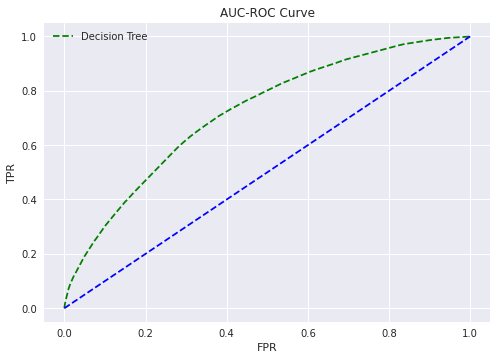

In [25]:
plt.style.use('seaborn')
plt.plot(fpr,tpr,linestyle = '--',color = 'green',label='Decision Tree')
plt.plot(p_fpr,p_tpr,linestyle='--',color = 'blue')
plt.legend()
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('AUC-ROC Curve')

In [26]:
y_pred = clf.predict(x_test)
precision = precision_score(y_test, y_pred, average = 'weighted')
recall = recall_score(y_test, y_pred, average = 'weighted')
print("Precision: %s, Recall: %s" %(precision, recall))

Precision: 0.794530319192747, Recall: 0.833915


In [27]:
matrix = confusion_matrix(y_test,y_pred)
tn, fp, fn, tp = matrix.ravel()
print(matrix)

[[328114   4118]
 [ 62316   5452]]


In [28]:
#For example:
#Here total_return and cost values are examples
total_return = 0.2
cost = 0.05
total_return = tp * total_return
total_cost = (tp + fp) * cost 
roi = total_return / total_cost
print("Total return: %s, Total cost: %s, ROI: %s" %(
  total_return, total_cost, roi))

Total return: 1090.4, Total cost: 478.5, ROI: 2.278787878787879


In [29]:
for max_depth_val in [2, 3, 5, 10, 15, 20]:
    clf = DecisionTreeClassifier(max_depth = max_depth_val)
    print("Evaluating tree with max_depth = %s" %(max_depth_val))
    y_pred = clf.fit(x_train,y_train).predict(x_test) 
    print("Confusion matrix: ")
    print(confusion_matrix(y_test, y_pred))
    prec = precision_score(y_test, y_pred, average = 'weighted')
    recall = recall_score(y_test, y_pred, average = 'weighted')
    print("Precision: %s, Recall: %s" %(prec, recall))

Evaluating tree with max_depth = 2
Confusion matrix: 
[[332232      0]
 [ 67768      0]]


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision: 0.6898631364, Recall: 0.83058
Evaluating tree with max_depth = 3
Confusion matrix: 
[[328106   4126]
 [ 63148   4620]]
Precision: 0.7860198996559663, Recall: 0.831815
Evaluating tree with max_depth = 5
Confusion matrix: 
[[328128   4104]
 [ 62997   4771]]
Precision: 0.7878780467978341, Recall: 0.8322475
Evaluating tree with max_depth = 10
Confusion matrix: 
[[328115   4117]
 [ 62316   5452]]
Precision: 0.7945407452705467, Recall: 0.8339175
Evaluating tree with max_depth = 15
Confusion matrix: 
[[326747   5485]
 [ 61427   6341]]
Precision: 0.789985554728142, Recall: 0.83272
Evaluating tree with max_depth = 20
Confusion matrix: 
[[322050  10182]
 [ 59964   7804]]
Precision: 0.7737156178450145, Recall: 0.824635


In [31]:
from sklearn.model_selection import KFold,cross_val_score
# Set up k-fold
k_fold = KFold(n_splits = 5)

# Evaluate precision and recall for each fold
precision = cross_val_score(
  clf, x_train, y_train, cv = k_fold, scoring = 'precision_weighted')
recall = cross_val_score(
  clf, x_train, y_train, cv = k_fold, scoring = 'recall_weighted')
print("Precision scores: %s" %(precision)) 
print("Recall scores: %s" %(recall))
print(k_fold)

Precision scores: [0.77164913 0.77221332 0.77048112 0.7713491  0.77057404]
Recall scores: [0.82349688 0.82249063 0.82241562 0.82345313 0.82273125]
KFold(n_splits=5, random_state=None, shuffle=False)


In [ ]:
for max_depth_val in [3, 5, 10]:
    k_fold = KFold(n_splits = 4)
    clf = DecisionTreeClassifier(max_depth = max_depth_val)
    print("Evaluating Decision Tree for max_depth = %s" %(max_depth_val))
    y_pred = clf.fit(x_train, y_train).predict(x_test) 
  
    cv_precision = cross_val_score(clf, x_train, y_train, cv = k_fold, scoring = 'recall_weighted')
    precision = recall_score(y_test, y_pred, average = 'weighted')
    print("Cross validation Recall: %s" %(cv_precision))
    print("Test Recall: %s" %(precision))
  

In [37]:
from sklearn.tree import export_graphviz
from six import StringIO
import pydot as pydot
import graphviz
from IPython.display import Image

dot_data = export_graphviz(clf,out_file=None,filled=True,rounded=True,special_characters=True)
graph = graphviz.Source(dot_data)
graph


KeyboardInterrupt: 